# Gamma Regression (California Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [12]:
from xgboostlss.model import *
from xgboostlss.distributions.Gamma import *

from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing

# Data

In [2]:
n_cpu = multiprocessing.cpu_count()

housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
    Gamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [4]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-05-18 08:29:58,928] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-05-18 08:30:11,999] Trial 0 finished with value: 4221.315039 and parameters: {'eta': 0.0007956486113255149, 'max_depth': 4, 'gamma': 9.651293834004364e-06, 'subsample': 0.9299029412512503, 'colsample_bytree': 0.533212122378312, 'min_child_weight': 1.0645031471691002e-06, 'booster': 'gbtree'}. Best is trial 0 with value: 4221.315039.
[I 2023-05-18 08:30:31,329] Trial 1 finished with value: 4704.1411134 and parameters: {'eta': 1.5405304565767472e-05, 'max_depth': 8, 'gamma': 1.2567045481680053e-06, 'subsample': 0.8546851597908047, 'colsample_bytree': 0.7705937486648105, 'min_child_weight': 0.06607432187087299, 'booster': 'gbtree'}. Best is trial 0 with value: 4221.315039.
[I 2023-05-18 08:30:43,968] Trial 2 finished with value: 4700.0834962 and parameters: {'eta': 4.0285972682401886e-05, 'max_depth': 2, 'gamma': 2.9603310576396133e-08, 'subsample': 0.32250688445301023, 'colsample_bytree': 0.6536953349316124, 'min_child_weight': 1.4342277391569358e-06, 'booster': 'gbtree'}. Best i

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.876505,1.673667,2.938326,1.454809,2.399422,1.759965,1.460128,1.688740,1.784902,2.417931,...,1.839925,1.887811,1.534427,1.326183,2.398682,0.998292,2.434605,0.991851,1.505856,1.574307
1,0.883587,1.291906,1.248149,0.884646,1.047550,0.854057,1.182763,0.746962,1.074761,0.996688,...,0.876435,0.843717,0.897013,1.137278,0.555706,0.678625,1.023129,0.808541,0.920332,1.241407
2,1.030200,1.531222,1.095772,1.081247,1.793127,1.450662,1.419437,1.132455,1.276576,0.867061,...,1.843388,1.766897,1.958323,1.276894,1.933600,1.407317,1.600355,1.875028,1.435953,1.653420
3,1.880502,0.746944,0.865230,1.270051,1.455336,1.308650,1.336325,1.357684,1.764968,1.272650,...,1.868246,1.713741,1.608263,1.418744,1.705131,1.168589,2.756223,1.554872,1.339272,2.297941
4,5.162236,7.503895,6.175812,4.588247,4.577571,3.859889,4.225744,4.521331,5.302205,5.370818,...,6.098175,4.018948,6.255476,4.507837,5.130795,3.461627,3.558900,4.876582,4.760717,5.481852


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,1.227181,2.881343
1,0.515992,1.314277
2,0.907038,2.034687
3,1.101743,2.639123
4,3.463038,6.704498


In [9]:
pred_params.head()

,concentration,rate
0,15.969825,8.100084
1,13.882849,15.841588
2,16.768461,11.691557
3,14.617913,8.024559
4,23.413013,4.779128


# SHAP Interpretability

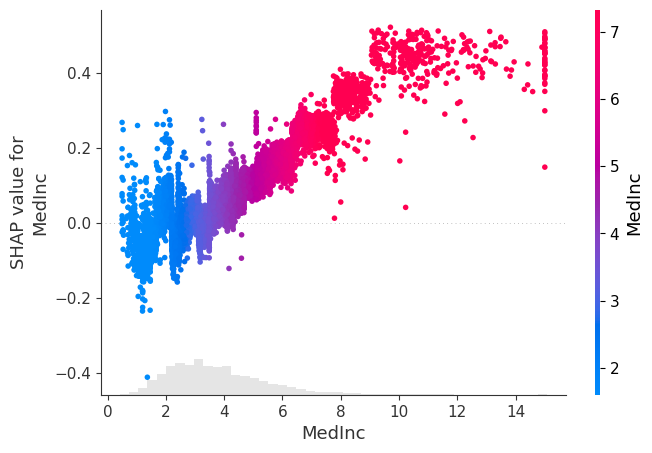

In [10]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
xgblss.plot(pdp_df,
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

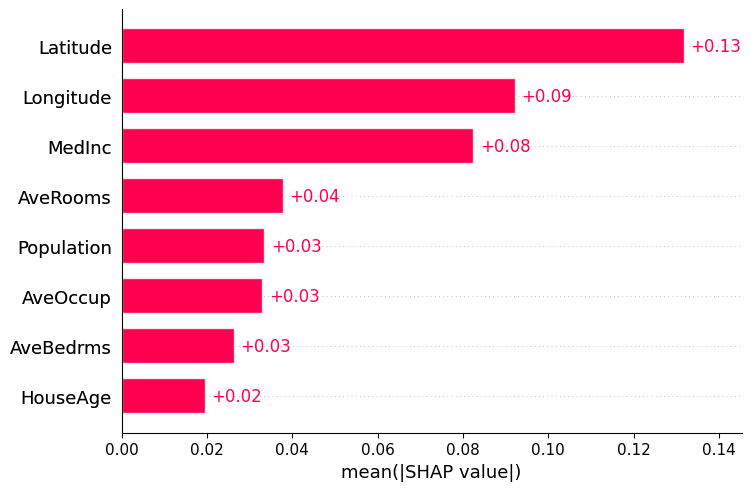

In [11]:
# Feature Importance
xgblss.plot(pdp_df,
            parameter="concentration",
            plot_type="Feature_Importance")